In [58]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

def plot_battery_data(data, n_period=None, metrics=None):
    """
    Plots status (top), tension/voltage (middle), and current + state changes (bottom).

    Parameters:
        data (pd.DataFrame): cell data
        n_period (int, optional): Specific period number to focus on. Default=None.
        metrics (pd.DataFrame, optional): DataFrame containing metrics for each status period. Default=None.
    """
    data = data.copy()

    # --- determine start/end from metrics if provided (robust: try loc then iloc) ---
    start, end = None, None
    if n_period is not None and metrics is not None:
        row = None
        try:
            row = metrics.loc[n_period]
        except Exception:
            try:
                row = metrics.iloc[int(n_period)]
            except Exception:
                row = None
        if row is not None:
            try:
                start = float(row["start_time"])
                end = float(row["end_time"])
            except Exception:
                start, end = None, None

    # Filter data based on start and end time if provided
    if start is not None:
        data = data[data["Time"] >= start]
    if end is not None:
        data = data[data["Time"] <= end]

    # --- sanitise / sort data to avoid plotting artifacts ---
    # ensure Time is numeric and sorted (prevents lines jumping when timestamps out of order)
    data["Time"] = pd.to_numeric(data["Time"], errors="coerce")
    data = data.sort_values("Time").reset_index(drop=True)

    # ensure I and U are numeric
    data["I"] = pd.to_numeric(data["I"], errors="coerce")
    data["U"] = pd.to_numeric(data["U"], errors="coerce")
    data["Line"] = pd.to_numeric(data["Line"], errors="coerce").fillna(method="ffill")

    # fixed order + fallback
    fixed_order = ["CV Discharge", "CC Discharge", "Rest", "CV Charge", "CC Charge", "Current Pulses"]
    present = list(data["status"].dropna().unique())
    unique_statuses = [s for s in fixed_order if s in present]
    if not unique_statuses:
        unique_statuses = [s for s in present if pd.notna(s)]

    if unique_statuses:
        cat_type = CategoricalDtype(categories=unique_statuses, ordered=True)
        data["status"] = data["status"].astype(cat_type)
        data["status_num"] = data["status"].cat.codes
    else:
        data["status_num"] = 0

    # transitions by Line changes
    data["Change"] = data["Line"].diff().fillna(0)
    transitions = data[data["Change"] != 0]

    # three stacked subplots: status, tension, current
    fig, (ax_status, ax_tension, ax_current) = plt.subplots(
        3, 1, sharex=True, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1, 2]}
    )

    # top: status
    if unique_statuses:
        ax_status.plot(data["Time"], data["status_num"], color="purple", linestyle="--")
        ax_status.set_yticks(range(len(unique_statuses)))
        ax_status.set_yticklabels(unique_statuses)
    else:
        ax_status.text(0.5, 0.5, "No status data", ha="center", va="center")
    ax_status.set_ylabel("Status")
    ax_status.grid(axis="y", linestyle="--", alpha=0.5)

    # middle: tension / voltage
    ax_tension.plot(data["Time"], data["U"], color="green", label="Voltage [V]")
    ax_tension.set_ylabel("Voltage [V]")
    ax_tension.grid(True, linestyle="--", alpha=0.4)
    ax_tension.legend(loc="best")

    # bottom: current and state-changes
    ax_current.plot(data["Time"], data["I"], color="blue", label="Current [A]")
    if not transitions.empty:
        ax_current.scatter(transitions["Time"], transitions["I"], color="red", s=40, marker="o", label="State Changes")
    ax_current.set_ylabel("Current [A]")
    ax_current.set_xlabel("Time [s]")
    ax_current.grid(True, linestyle="--", alpha=0.4)
    ax_current.legend(loc="best")

    ax_status.set_title("Battery Operating States / Signals")
    plt.tight_layout()
    plt.show()

def plot_battery_status(data, start=None, end=None):
    """
    Plots only the battery operating status over time.

    Parameters:
        data (dict): cell data
        start (float, optional): Start time for the plot. Default=None.
        end (float, optional): End time for the plot. Default=None.
    """

    # Filter by start and end time if provided
    if start is not None:
        data = data[data["Time"] >= start]
    if end is not None:
        data = data[data["Time"] <= end]

    # Fixed status order
    fixed_order = ["CV Discharge", "CC Discharge", "Rest", "CV Charge", "CC Charge", "Current Pulses"]
    unique_statuses = [s for s in fixed_order if s in data["status"].unique()]

    # Convert status to categorical type with fixed order
    cat_type = CategoricalDtype(categories=unique_statuses, ordered=True)
    data["status"] = data["status"].astype(cat_type)
    data["status_num"] = data["status"].cat.codes

    # Create figure
    plt.figure(figsize=(12, 5))

    # Plot status curve
    plt.plot(data["Time"], data["status_num"], label="Battery Status")

    # Set custom Y-axis labels
    plt.yticks(range(len(unique_statuses)), unique_statuses)

    # Labels and title
    plt.title("Battery Operating Status Over Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Battery Status")
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.show()

def load_cell_data(file_path):
    """
    Load the battery dataset from a .mat file.

    Parameters:
        file_path (str): Path to the .mat file.

    Returns:
        dict: Dictionary containing the dataset fields.
    """
    data = loadmat(file_path, squeeze_me=True, struct_as_record=False)["Dataset"]
    data = data.__dict__
    columns = ["Time", "Line", "I", "U", "status", "T1"]
    data = pd.DataFrame(data, columns=columns)

    return data


def process_states(path):
    """
    Process the battery dataset and assign operational states based on the 'Line' column.

    Parameters:
        path (str): Path to the .mat dataset file.

    Returns:
        dict: Dataset including the computed 'status' column.
    """
    data = load_cell_data(path)

    # Define operational states based on 'Line' value ranges
    data["status"] = np.where(data["Line"] <= 13, "Rest", "")
    data["status"] = np.where((data["Line"] > 13) & (data["Line"] < 15), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 14) & (data["Line"] < 16), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 15) & (data["Line"] < 17), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 16) & (data["Line"] < 19), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 19) & (data["Line"] < 21), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 20) & (data["Line"] < 22), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 21) & (data["Line"] < 23), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 22) & (data["Line"] < 24), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 23) & (data["Line"] < 26), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 26) & (data["Line"] < 28), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 27) & (data["Line"] < 33), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 32) & (data["Line"] < 34), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 33) & (data["Line"] < 35), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 34) & (data["Line"] < 36), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 35) & (data["Line"] < 37), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 37) & (data["Line"] < 42), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 41) & (data["Line"] < 43), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 42) & (data["Line"] < 44), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 43) & (data["Line"] < 49), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 48) & (data["Line"] < 50), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 49) & (data["Line"] < 51), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 50) & (data["Line"] < 56), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 55), "Rest", data["status"])
    return data

def analyze_metrics_by_status_period(data):
    """
    Analyze and compute metrics for each continuous period of a specific battery status.
    Parameters:
        data (dict): cell data 
    Returns:
        pd.DataFrame: DataFrame containing metrics for each status period.
    """

    # Identify changes in status to segment the data
    data["status_change"] = (data["status"] != data["status"].shift()).cumsum()

    # Group by status change segments
    grouped = data.groupby("status_change")

    results = []
    for _, g in grouped:

        subset = g.iloc[3:-3]

        if subset.empty or subset["status"].isna().all():
            continue

        status = subset["status"].iloc[0]
        start_time = subset["Time"].iloc[0]
        end_time = subset["Time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["I"].mean()
        std_current = subset["I"].std()

        avg_tension = subset["U"].mean()
        std_tension = subset["U"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    return pd.DataFrame(results)

In [36]:

import os

# Load and process data
for paste in ["../data_pub"]:
    for root, dirs, files in os.walk(paste):
        for file in files:
            if file.endswith(".mat"):
                metrics = analyze_metrics_by_status_period(process_states(os.path.join(root, file)))

                # Check if CC periods have std_current > 0.05
                cc_issues = metrics[(metrics["status"] == "CC Charge") | (metrics["status"] == "CC Discharge")]
                cc_issues = cc_issues[cc_issues["std_current"] > 0.05]
                for issue in cc_issues.itertuples():
                    print(f"File: {os.path.join(root, file)}, Issue in {issue.status} from {issue.start_time} to {issue.end_time} with std_current {issue.std_current}")

                # Check if CV periods have std_tension > 0.05
                cv_issues = metrics[(metrics["status"] == "CV Charge") | (metrics["status"] == "CV Discharge")]
                cv_issues = cv_issues[cv_issues["std_tension"] > 0.05]
                for issue in cv_issues.itertuples():
                    print(f"File: {file}, Issue in {issue.status} from {issue.start_time} to {issue.end_time} with std_tension {issue.std_tension}")

                # Check if charges have avg_current < 0
                charge_issues = metrics[(metrics["status"] == "CC Charge") | (metrics["status"] == "CV Charge")]
                charge_issues = charge_issues[charge_issues["avg_current"] < 0]
                for issue in charge_issues.itertuples():
                    print(f"File: {file}, Issue in {issue.status} from {issue.start_time} to {issue.end_time} with avg_current {issue.avg_current}")

                # Check if discharges have avg_current > 0
                discharge_issues = metrics[(metrics["status"] == "CC Discharge") | (metrics["status"] == "CV Discharge")]  
                discharge_issues = discharge_issues[discharge_issues["avg_current"] > 0]
                for issue in discharge_issues.itertuples():
                    print(f"File: {file}, Issue in {issue.status} from {issue.start_time} to {issue.end_time} with avg_current {issue.avg_current}")


File: ../data_pub/CU_Calendar/CU006/BW-VTC-174_4105_CU_cal_006_BW-VTC-CAL.mat, Issue in CC Discharge from 3.00565397208436 to 25.0945428578539 with std_current 0.3543105472864953
File: ../data_pub/CU_Cyclic/CU010_cyc/BW-VTC-232_3588_CU_cyc_010_BW-VTC-CYC2.mat, Issue in CC Discharge from 65930.3787513186 to 66360.378737912 with std_current 0.327697507275951
File: BW-VTC-395_3282_CU_cyc_002_BW-VTC-SupPos.mat, Issue in CV Discharge from 9.8564889626 to 9.9919161152 with std_tension 0.07631592079418716
File: ../data_pub/CU_Cyclic/CU007_cyc/BW-VTC-232_3155_CU_cyc_007_BW-VTC-CYC2.mat, Issue in CC Discharge from 24.2464955063267 to 24.3742732873645 with std_current 0.07615900082108763
File: ../data_pub/CU_Cyclic/CU003_cyc/BW-VTC-253_1191_CU_cyc_003_BW-VTC-CYC.mat, Issue in CC Discharge from 3.0056552242 to 3.7947299735 with std_current 0.20833071072926093
File: ../data_pub/CU_Cyclic/CU003_cyc/BW-VTC-251_1193_CU_cyc_003_BW-VTC-CYC.mat, Issue in CC Discharge from 3.0056560037 to 3.2529773618 wi

In [59]:
data = process_states("../data_pub/CU_Dynamic/CU005/BW-VTC-447_7686_CU_cyc_005_BW-VTC-AgeVal.mat")
metrics = analyze_metrics_by_status_period(data)
metrics

,status,start_time,end_time,duration,avg_current,std_current,avg_tension,std_tension
0,Rest,0.000001,2.991700,2.991699,0.000000,0.000000e+00,3.739614,1.247086e-03
1,CC Discharge,3.005655,3.427877,0.422222,-2.499991,1.814158e-05,3.364572,2.282382e-01
2,Rest,3.436940,5.423051,1.986111,0.000000,0.000000e+00,3.050885,5.219907e-02
3,CC Charge,5.437006,6.253672,0.816667,2.499999,1.296688e-05,3.815675,2.161665e-01
4,CV Charge,6.266553,6.585499,0.318946,0.505068,5.746641e-01,4.199780,2.681857e-04
5,CC Discharge,6.599483,7.493927,0.894444,-2.499996,1.786778e-05,3.629572,3.065236e-01
6,CV Discharge,7.506638,7.701083,0.194444,-0.146192,1.404688e-01,2.499865,3.863244e-05
7,Rest,7.710385,7.713162,0.002778,0.000000,0.000000e+00,2.532004,6.606879e-03
8,CC Charge,7.727117,8.566006,0.838889,2.500000,1.052241e-05,3.800252,2.340837e-01
9,CV Charge,8.577500,8.893289,0.315789,0.504940,5.748430e-01,4.199773,2.715760e-04


/tmp/ipykernel_437273/1235921584.py:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Line"] = pd.to_numeric(data["Line"], errors="coerce").fillna(method="ffill")


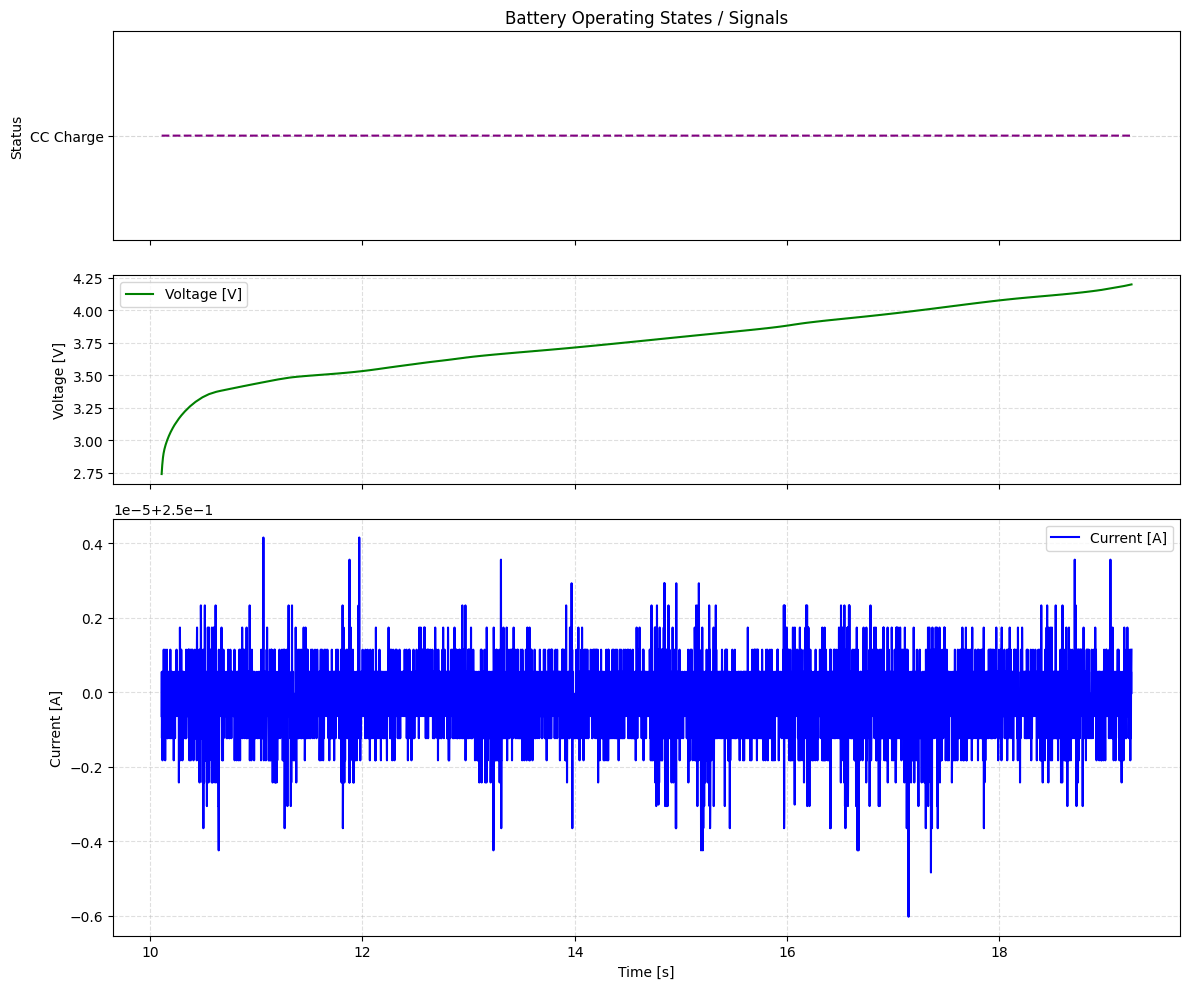

In [60]:
plot_battery_data(data, 13, metrics)